# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import scipy
from torchinfo import summary
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

# Import raw data

In [2]:
#Defining function to check if directory exists, if not it generates it
def check_and_make_dir(dir):
    if not os.path.isdir(dir):os.mkdir(dir)

#Base directory 
base_dir = '/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/'
#File containing surface temperature map
raw_ST_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_ST2D.csv', delimiter=',')

#Path to load NN model
NN_model_load_path = base_dir+'Model_Storage/NN_ST_server_stand_norm/'

#Path to store comparison plots
plot_save_path = base_dir+'Plots/ST_GP_vs_NN/'
check_and_make_dir(plot_save_path)

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_ST_data[:, :4] #has shape 46 x 72 = 3,312
raw_outputs = raw_ST_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features

## HYPER-PARAMETERS ##
#Defining partition of data used for 1. training, 2. validation and 3. testing
data_partitions = [0.7, 0.1, 0.2]

#Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_threads = 1
torch.set_num_threads(num_threads)
print(f"Using {device} device with {num_threads} threads")
torch.set_default_device(device)

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4
rng = torch.Generator(device=device)
rng.manual_seed(partition_seed)

# Variable to show plots or not 
show_plot = False

## GP
#Number of nearest neighbors to choose
N_neigbors = 10

#Distance metric to use
distance_metric = 'euclidean' #options: 'euclidean', 'mahalanobis', 'logged_euclidean', 'logged_mahalanobis'

#Convert raw inputs for H2 and CO2 pressures to log10 scale so don't have to deal with it later
if 'logged' in distance_metric:
    raw_inputs[:, 0] = np.log10(raw_inputs[:, 0]) #H2
    raw_inputs[:, 1] = np.log10(raw_inputs[:, 1]) #CO2

## NN

#Optimizer learning rate
learning_rate = 1e-3

#Regularization coefficient
regularization_coeff = 0.0

#Weight decay 
weight_decay = 0.0

#Batch size 
batch_size = 200

#Number of epochs 
n_epochs = 2000

Using cpu device with 1 threads


# Partition data and build Data Module

In [3]:
# PyTorch Lightning DataModule
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_inputs, train_outputs, valid_inputs, valid_outputs, 
                 test_inputs, test_outputs, batch_size, rng, reshape_for_cnn=False, 
                 img_channels=1, img_height=None, img_width=None):
        super().__init__()

        #Store original shapes for reshaping 
        self.batch_size = batch_size
        self.rng = rng
        self.reshape_for_cnn = reshape_for_cnn
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        
        # Standardizing the output
        ## Create scaler
        out_scaler = StandardScaler()
        
        ## Fit scaler on training dataset (convert to numpy)
        out_scaler.fit(train_outputs.numpy())
        
        ## Transform all datasets and convert back to tensors
        train_outputs = torch.tensor(out_scaler.transform(train_outputs.numpy()), dtype=torch.float32)
        valid_outputs = torch.tensor(out_scaler.transform(valid_outputs.numpy()), dtype=torch.float32)
        test_outputs = torch.tensor(out_scaler.transform(test_outputs.numpy()), dtype=torch.float32)
        
        # Store the scaler if you need to inverse transform later
        self.out_scaler = out_scaler
        
        # Normalizing the input
        ## Create scaler
        in_scaler = MinMaxScaler()
        
        ## Fit scaler on training dataset (convert to numpy)
        in_scaler.fit(train_inputs.numpy())
        
        ## Transform all datasets and convert back to tensors
        train_inputs = torch.tensor(in_scaler.transform(train_inputs.numpy()), dtype=torch.float32)
        valid_inputs = torch.tensor(in_scaler.transform(valid_inputs.numpy()), dtype=torch.float32)
        test_inputs = torch.tensor(in_scaler.transform(test_inputs.numpy()), dtype=torch.float32)
        
        # Store the scaler if you need to inverse transform later
        self.in_scaler = in_scaler
        
        #Store the inputs
        self.train_inputs = train_inputs
        self.valid_inputs = valid_inputs
        self.test_inputs = test_inputs

        # Reshape data if needed for CNN
        if reshape_for_cnn:
            # Reshape inputs
            if img_height is None or img_width is None:
                # Auto-calculate square dimensions if not provided
                total_labels = train_outputs.shape[1]
                img_size = int(np.sqrt(total_labels / img_channels))
                if img_size * img_size * img_channels != total_labels:
                    raise ValueError(f"Cannot reshape {total_labels} features into square image. "
                                     f"Please provide img_height and img_width explicitly.")
                self.img_height = img_size
                self.img_width = img_size
            
            self.train_outputs = train_outputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.valid_outputs = valid_outputs.reshape(-1, img_channels, self.img_height, self.img_width)
            self.test_outputs = test_outputs.reshape(-1, img_channels, self.img_height, self.img_width)

        else:
            self.train_outputs = train_outputs
            self.valid_outputs = valid_outputs
            self.test_outputs = test_outputs
    
    def train_dataloader(self):
        dataset = TensorDataset(self.train_inputs, self.train_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=self.rng)
    
    def val_dataloader(self):
        dataset = TensorDataset(self.valid_inputs, self.valid_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)
    
    def test_dataloader(self):
        dataset = TensorDataset(self.test_inputs, self.test_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)

#Splitting the data 

## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(N), data_partitions, generator=rng)

## Generate the data partitions
### Training
train_inputs = torch.tensor(raw_inputs[train_idx], dtype=torch.float32)
train_outputs = torch.tensor(raw_outputs[train_idx], dtype=torch.float32)
### Validation
valid_inputs = torch.tensor(raw_inputs[valid_idx], dtype=torch.float32)
valid_outputs = torch.tensor(raw_outputs[valid_idx], dtype=torch.float32)
### Testing
test_inputs = torch.tensor(raw_inputs[test_idx], dtype=torch.float32)
test_outputs = torch.tensor(raw_outputs[test_idx], dtype=torch.float32)

# Create DataModule
data_module = CustomDataModule(
    train_inputs, train_outputs,
    valid_inputs, valid_outputs,
    test_inputs, test_outputs,
    batch_size, rng, reshape_for_cnn=True,
    img_channels=1, img_height=46, img_width=72
)

# Fit data with Ensemble Conditional GP

## Build Conditional GP function

In [4]:
def Sai_CGP(obs_features, obs_labels, query_features):
    """
    Conditional Gaussian Process
    Inputs: 
        obs_features : ndarray (D, N)
            D-dimensional features of the N ensemble data points.
        obs_labels : ndarray (K, N)
            K-dimensional labels of the N ensemble data points.
        query_features : ndarray (D, 1)
            D-dimensional features of the query data point.
    Outputs:
        query_labels : ndarray (K, N)
            K-dimensional labels of the ensemble updated from the query point.
        query_cov_labels : ndarray (K, K)
            K-by-K covariance of the ensemble labels.
    """
    
    # Defining relevant covariance matrices
    ## Between feature and label of observation data
    Cyx = (obs_labels @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and feature of observation data
    Cxy = (obs_features @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Between feature and feature of observation data
    Cxx = (obs_features @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and label of observation data
    Cyy = (obs_labels @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Adding regularizer to avoid singularities
    Cxx += 1e-7 * np.eye(Cxx.shape[0]) 

    query_labels = obs_labels + (Cyx @ scipy.linalg.pinv(Cxx) @ (query_features - obs_features))

    query_cov_labels = Cyy - Cyx @ scipy.linalg.pinv(Cxx) @ Cxy

    return query_labels, query_cov_labels

## Evaluating GP approach on test set

In [5]:
#Initialize array to store model outputs
test_GP_outputs = np.zeros(test_outputs.shape, dtype=float)

GP_train_inputs = np.copy(train_inputs.numpy())
GP_train_outputs = np.copy(train_outputs.numpy())

for query_idx, (test_input, test_output) in enumerate(zip(test_inputs.numpy(), test_outputs.numpy())):

    #Calculate proximity of query point to observations
    # Euclidian distance
    if 'euclidean' in distance_metric:
        distances = np.sqrt( (test_input[0] - GP_train_inputs[:,0])**2 + (test_input[1] - GP_train_inputs[:,1])**2 + (test_input[2] - GP_train_inputs[:,2])**2 + (test_input[3] - GP_train_inputs[:,3])**2 )
    # Mahalanobis distance
    elif 'mahalanobis' in distance_metric:
        distances = np.sqrt( (test_input - np.mean(GP_train_inputs, axis=0)).T @ scipy.linalg.inv((GP_train_inputs.T @ GP_train_inputs) / (GP_train_inputs.shape[0] - 1)) @ (test_input - np.mean(GP_train_inputs, axis=0)) )
    else:raise('Invalid distance metric')
    
    #Choose the N closest points
    N_closest_idx = np.argsort(distances)[:N_neigbors]
    prox_train_inputs = GP_train_inputs[N_closest_idx, :]
    prox_train_outputs = GP_train_outputs[N_closest_idx, :]
    
    #Find the query labels from nearest neigbours
    mean_test_output, cov_test_output = Sai_CGP(prox_train_inputs.T, prox_train_outputs.T, test_input.reshape((1, 4)).T)
    test_GP_outputs[query_idx, :] = np.mean(mean_test_output, axis=1)
    model_test_output_err = np.sqrt(np.diag(cov_test_output))

    #Diagnostic plot
    if show_plot:

        plt.figure(figsize=(8, 6))
        plt.imshow(cov_test_output, cmap='coolwarm', origin='lower')
        plt.colorbar(label='Covariance')
        plt.title('Joint Covariance Matrix')
        plt.xlabel('Output index')
        plt.ylabel('Output index')
        plt.show()

        #Convert shape
        plot_test_output = test_output.reshape((46, 72))
        plot_test_GP_output = test_GP_outputs[query_idx, :].reshape((46, 72))
        plot_res = plot_test_GP_output - plot_test_output
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(test_output)
        vmax = np.max(test_output)
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax2.set_title('Model')
        hm2 = sns.heatmap(plot_test_GP_output, ax=ax2)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        ax3.set_title('Residuals')
        hm3 = sns.heatmap(plot_res, ax=ax3)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm3.collections[0].colorbar
        cbar.set_label('Temperature (K)')
        # Shared colorbar (use the last heatmap's mappable)
        # cbar = fig.colorbar(hm3.get_children()[0], ax=[ax1, ax2, ax3], location='right')
        # cbar.set_label("Temperature")
        # Fix longitude ticks
        ax3.set_xticks(np.linspace(0, 72, 5))
        ax3.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax3.set_xlabel('Longitude (degrees)')
        # Fix latitude ticks
        for ax in [ax1, ax2, ax3]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')
        plt.suptitle(rf'H$_2$ : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.show()

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_2908/2831163366.py:26: RuntimeWarning: invalid value encountered in sqrt
  model_test_output_err = np.sqrt(np.diag(cov_test_output))


# Import CNN model

## Build CNN

In [6]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_channels):
        super(CNN, self).__init__()
        

        # Project input parameters to a higher dimension
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128 * 6 * 9)  # 6x9 feature maps with 128 channels
        )

        # Decoder layers - progressively upsample
        self.decoder = nn.Sequential(
            # Input: 128 x 6 x 9
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: 128 x 12 x 18
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Output: 64 x 24 x 36
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Output: 32 x 48 x 72
            
            # Fine-tune to exact dimensions (48x72 -> 46x72)
            nn.Conv2d(32, 16, kernel_size=(3,3), stride=1, padding=(0,1)),
            nn.ReLU(inplace=True),
            # Output: 16 x 46 x 72
            
            nn.Conv2d(16, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
            # Output: output_channels x 46 x 72
        )

    def forward(self, x):
        """
        Forward pass through the decoder.
        
        Args:
            x: Input tensor of shape (batch_size, input_dim)
            
        Returns:
            Generated images of shape (batch_size, output_channels, 46, 72)
        """
        # Project to higher dimension and reshape
        x = self.fc(x)
        x = x.view(-1, 128, 6, 9)  # Reshape to (batch, channels, height, width)
        
        # Decode to image
        x = self.decoder(x)
        
        return x

In [7]:
model = CNN(D,1).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,280
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       131,584
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       3,545,856
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-6              262,272
│    └─BatchNorm2d: 2-7                  256
│    └─ReLU: 2-8                         --
│    └─ConvTranspose2d: 2-9              131,136
│    └─BatchNorm2d: 2-10                 128
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             32,800
│    └─BatchNorm2d: 2-13                 64
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      4,624
│    └─ReLU: 2-16                        --
│    └─Conv2d: 2-17                      145
│    └─Sigmoid: 2-18                

## Define optimization block

In [8]:
# PyTorch Lightning Module
class RegressionModule(pl.LightningModule):
    def __init__(self, model, optimizer, learning_rate, weight_decay=0.0, reg_coeff=0.0):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.reg_coeff = reg_coeff
        self.weight_decay = weight_decay
        self.loss_fn = nn.MSELoss()
        self.optimizer_class = optimizer
    
    def compute_gradient_penalty(self, X):
        """
        Compute the gradient of model output with respect to input.
        Returns the L2 norm of the gradients as a regularization term.
        """
        if self.reg_coeff == 0:
            return torch.tensor(0., device=self.device)
        
        # Clone and enable gradient computation for inputs
        X_grad = X.clone().detach().requires_grad_(True)

        # Temporarily enable gradients (needed for validation/test steps)
        with torch.enable_grad():
            
            # Compute output (need to recompute to track gradients w.r.t. X)
            output = self.model(X_grad)
            
            # Compute gradients of output with respect to input
            grad_outputs = torch.ones_like(output)
            gradients = torch.autograd.grad(
                outputs=output,
                inputs=X_grad,
                grad_outputs=grad_outputs,
                create_graph=True,  # Keep computation graph for backprop
                retain_graph=True,
                only_inputs=True
            )[0]
            
            # Compute L2 norm of gradients (squared)
            gradient_penalty = torch.mean(gradients ** 2)
        
        return self.reg_coeff * gradient_penalty
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)
        
        # Add gradient regularization
        grad_penalty = self.compute_gradient_penalty(X)
        loss += grad_penalty

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)

        # Log metrics
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)

        # Log metrics
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer_class(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

## Retrieve optimization

In [9]:
# Create Lightning Module
lightning_module = RegressionModule(
    model=model,
    optimizer=SGD,
    learning_rate=learning_rate,
    reg_coeff=regularization_coeff,
    weight_decay=weight_decay
)

# Setup logger
logger = CSVLogger(NN_model_load_path+'logs', name='NeuralNetwork')

# Create Trainer and train
trainer = Trainer(
    max_epochs=n_epochs,
    logger=logger,
    deterministic=True  # For reproducibility
)

# Load model
lightning_module = RegressionModule.load_from_checkpoint(
    NN_model_load_path + f'{n_epochs}epochs_{regularization_coeff}WD_{regularization_coeff}RC_{learning_rate}LR_{batch_size}BS.ckpt',
    model=model,
    optimizer=SGD,
learning_rate=learning_rate,
reg_coeff=regularization_coeff,
weight_decay=weight_decay
)
print("Model loaded!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Model loaded!


## Diagnostic plots

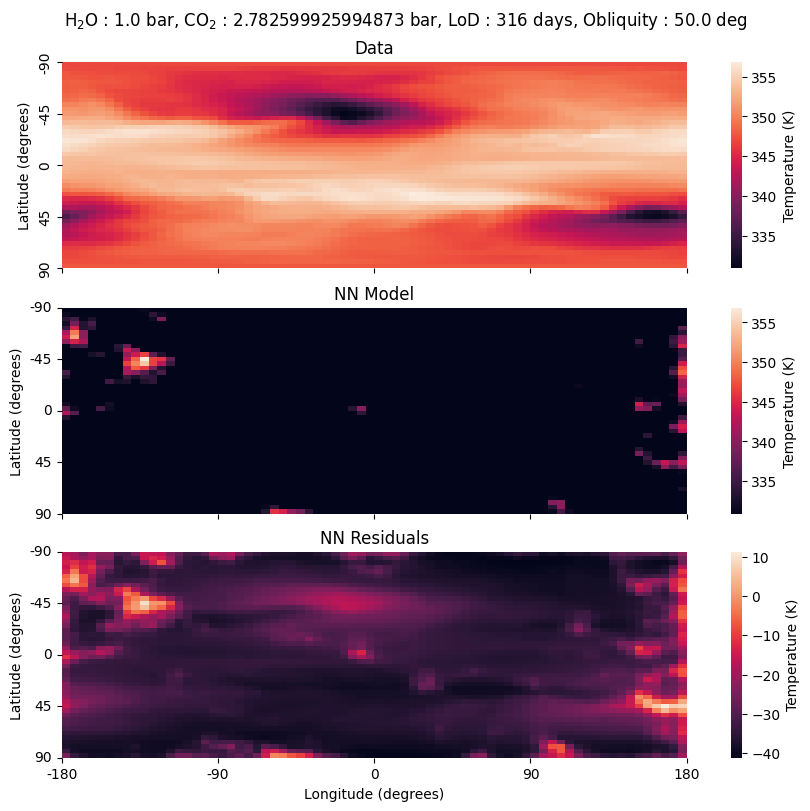

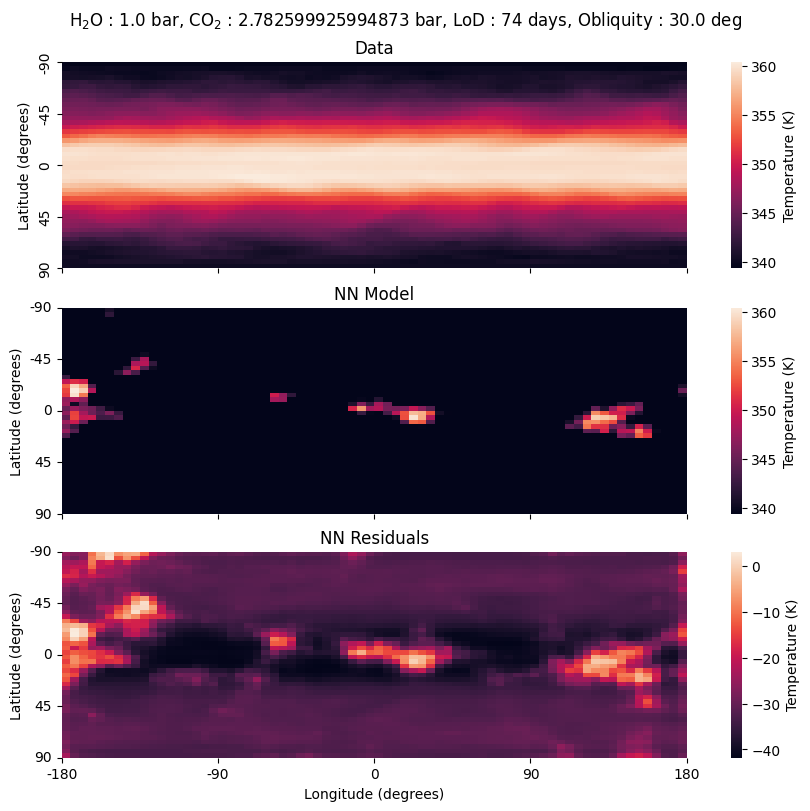

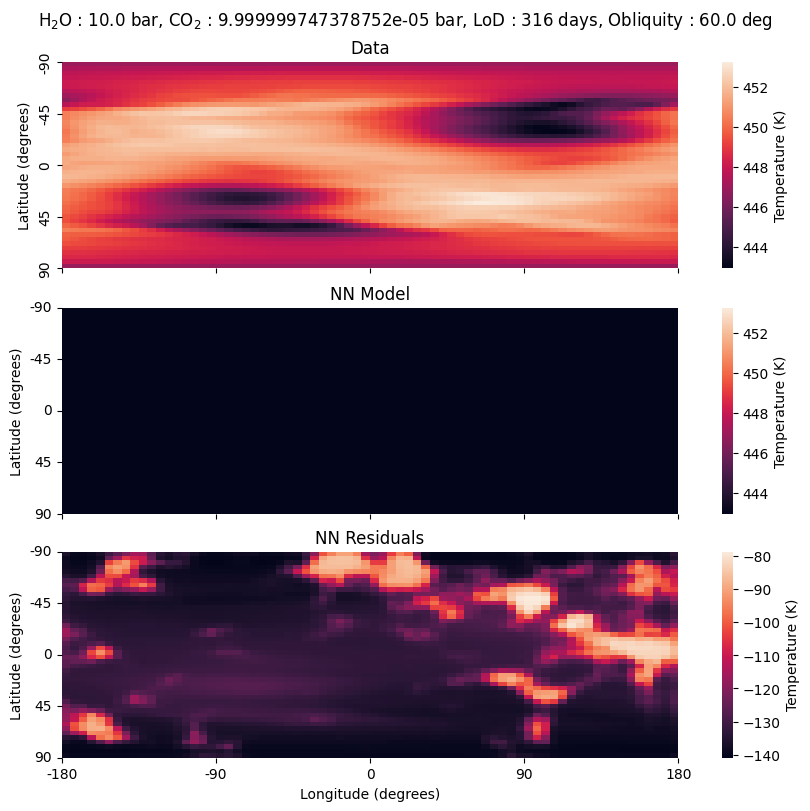

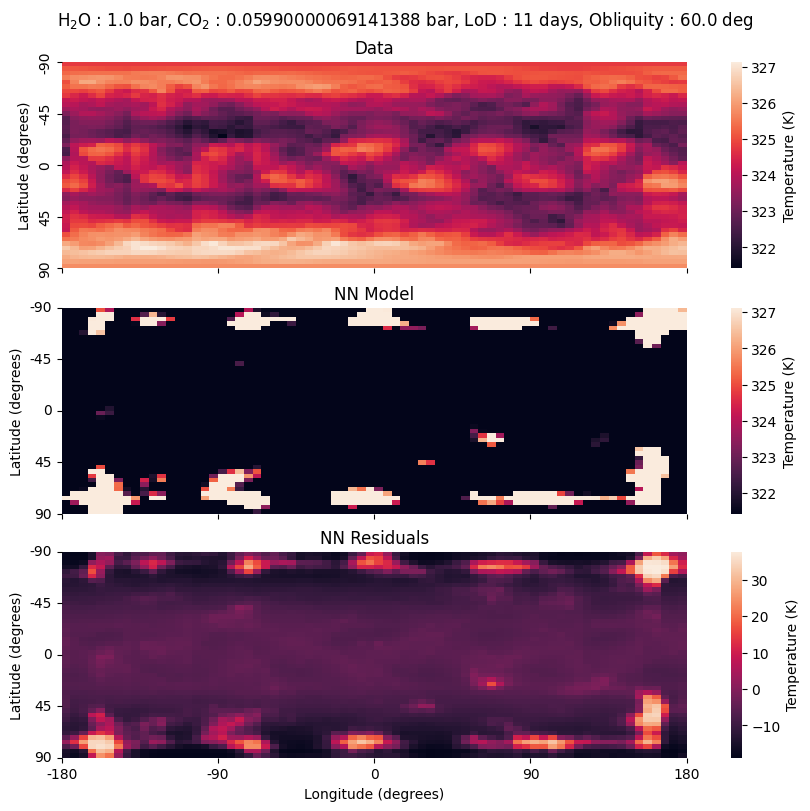

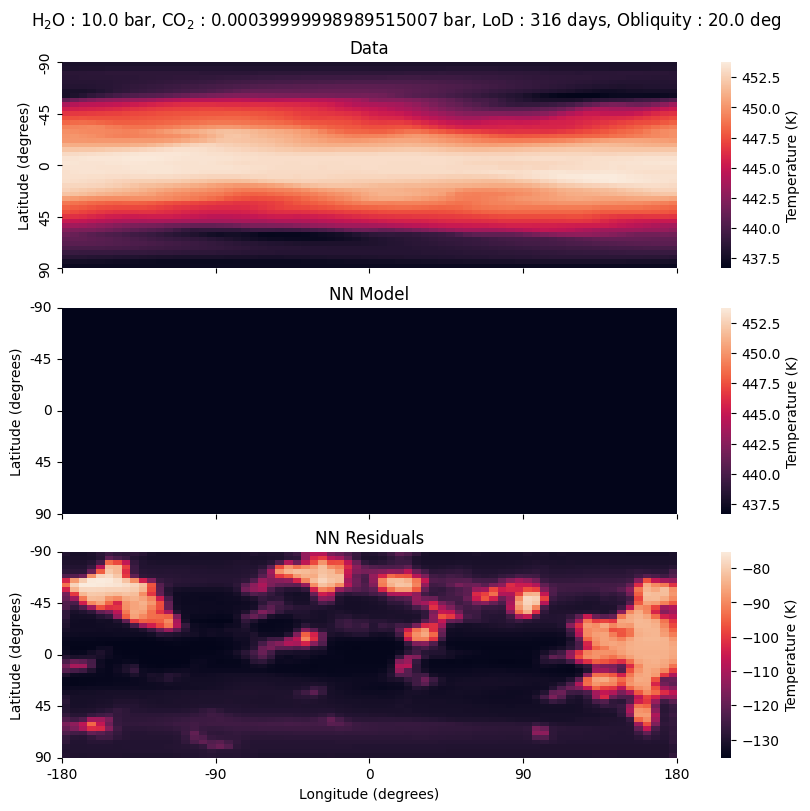

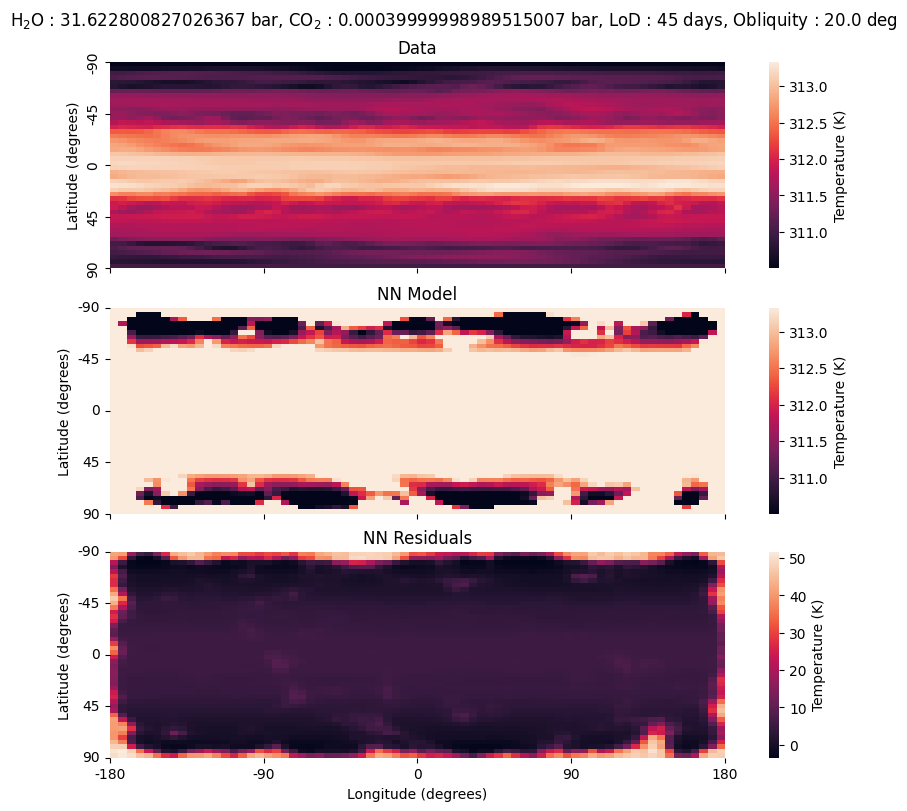

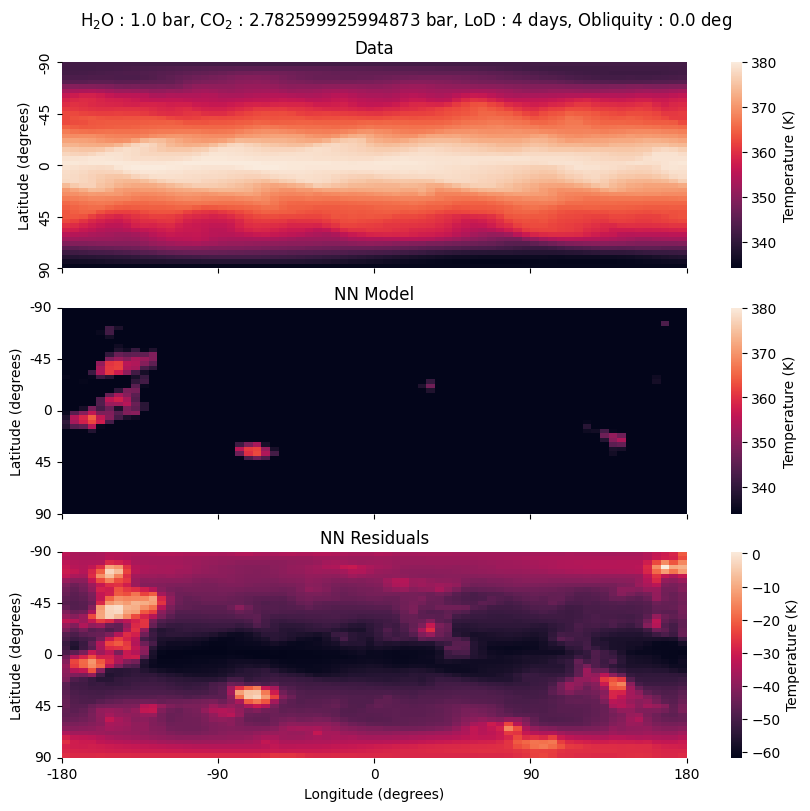

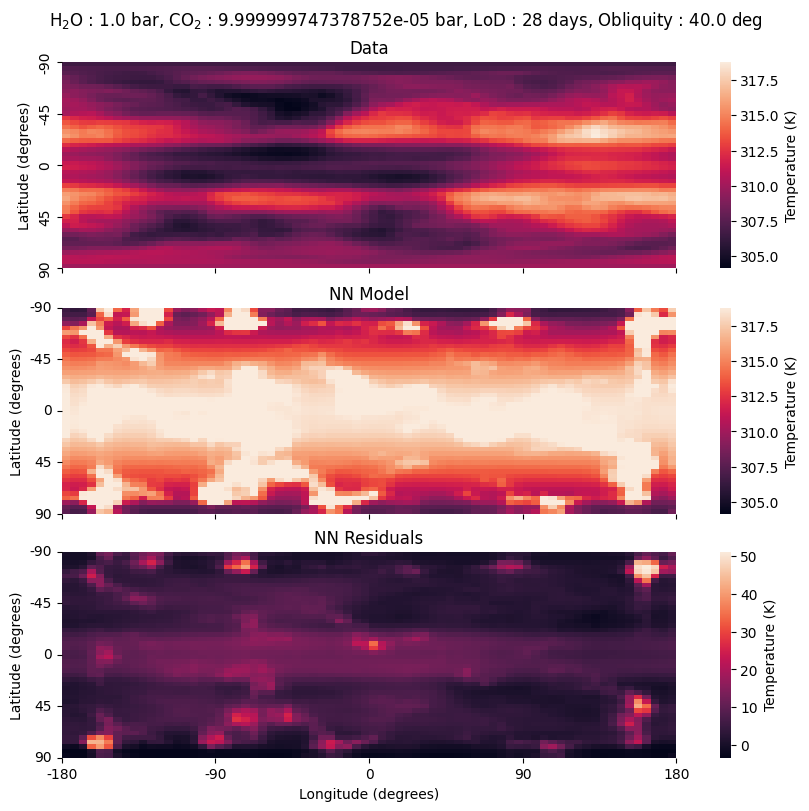

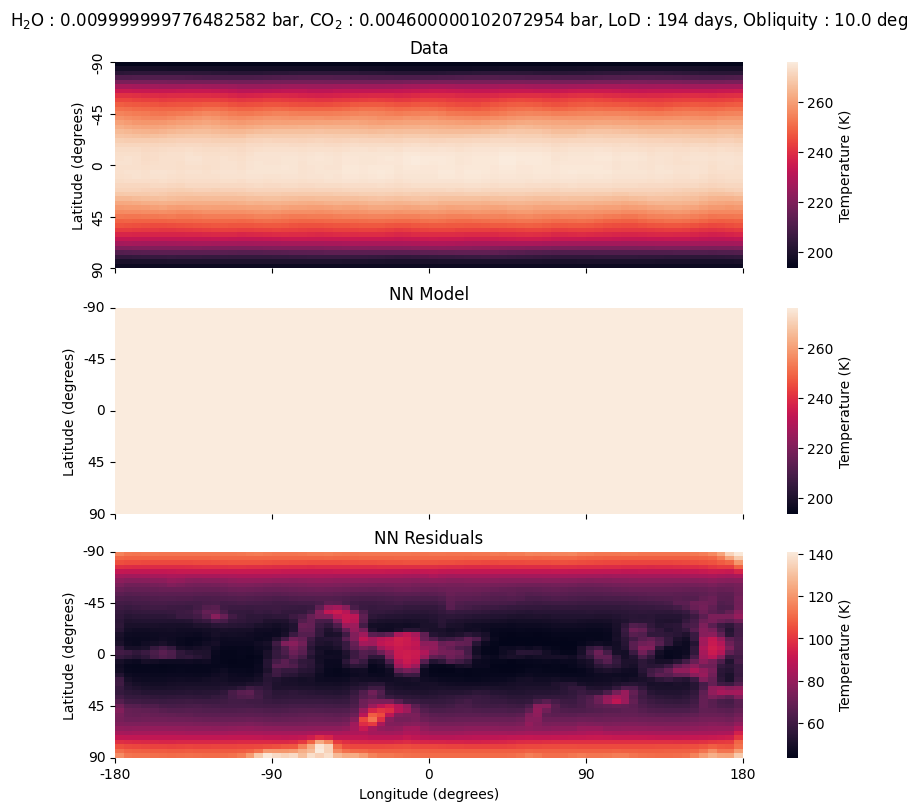

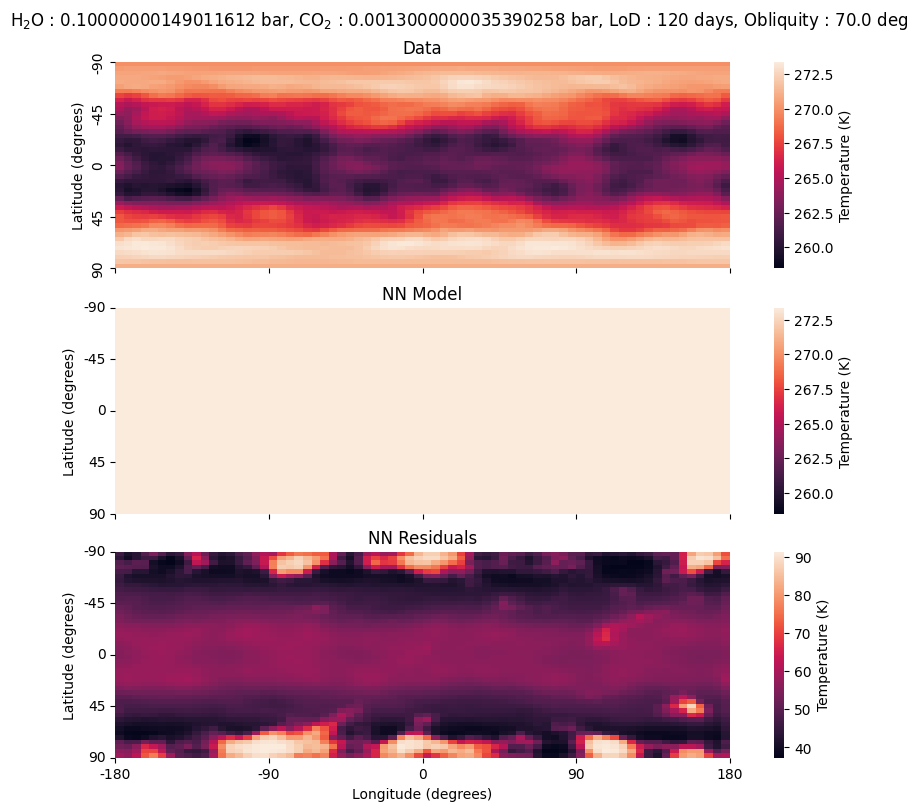

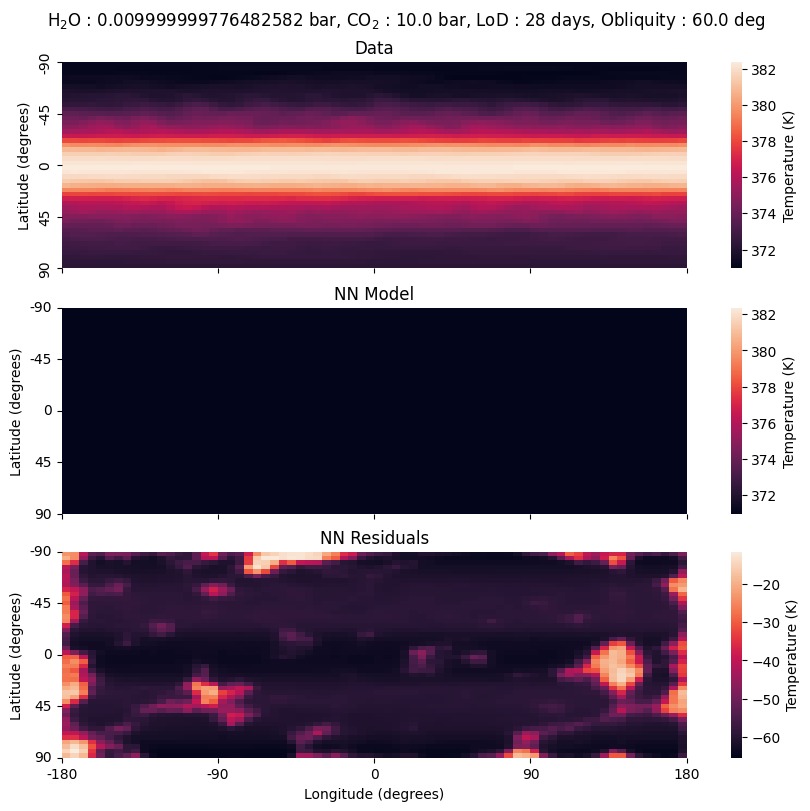

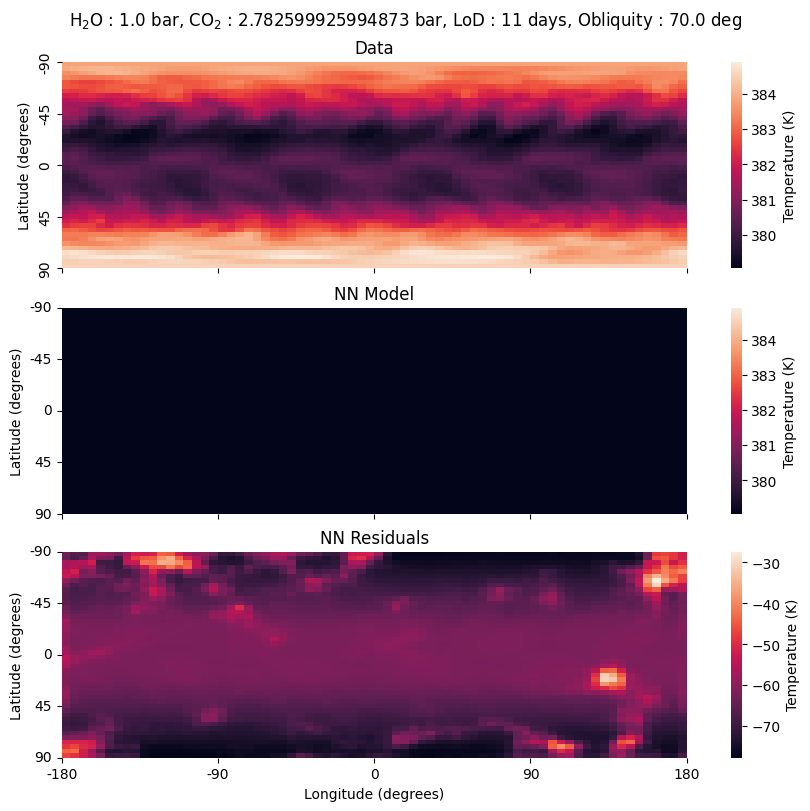

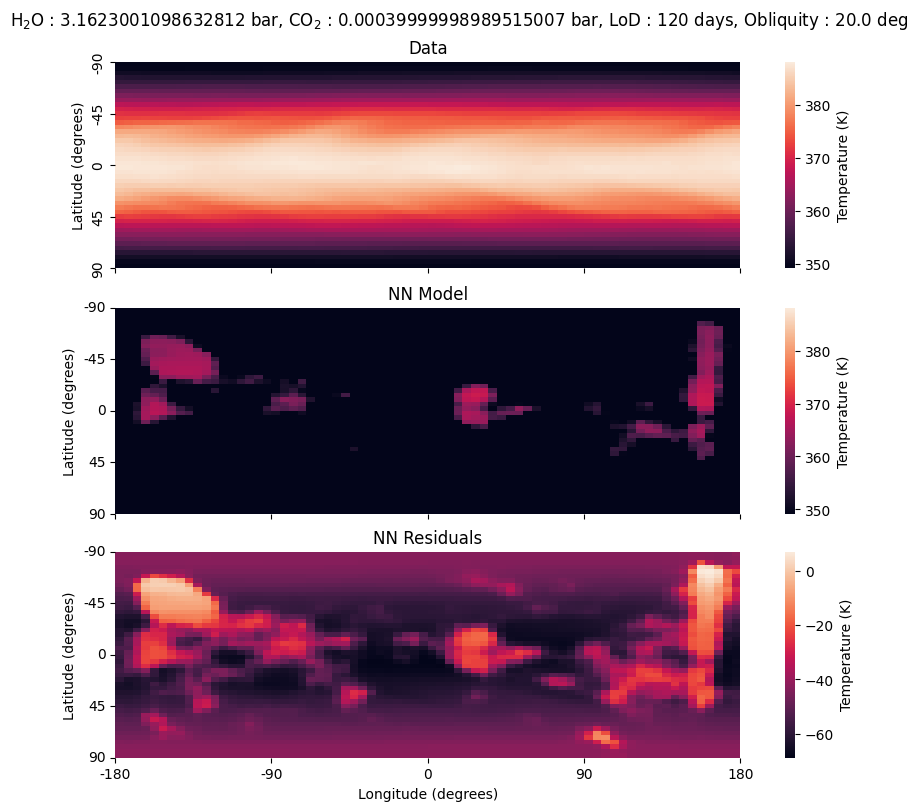

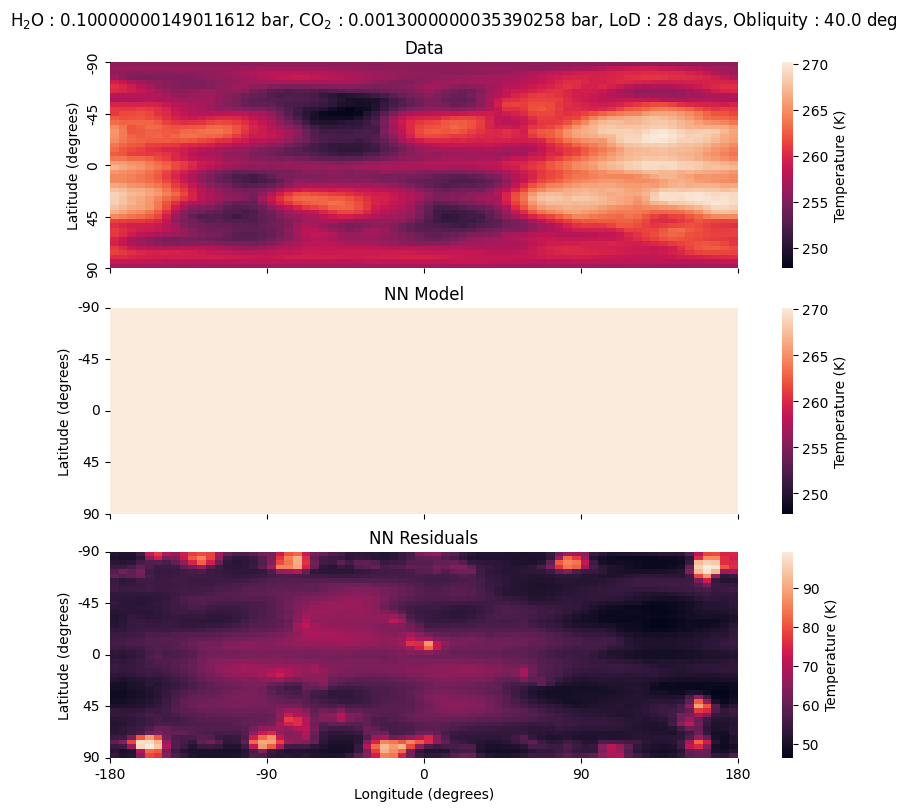

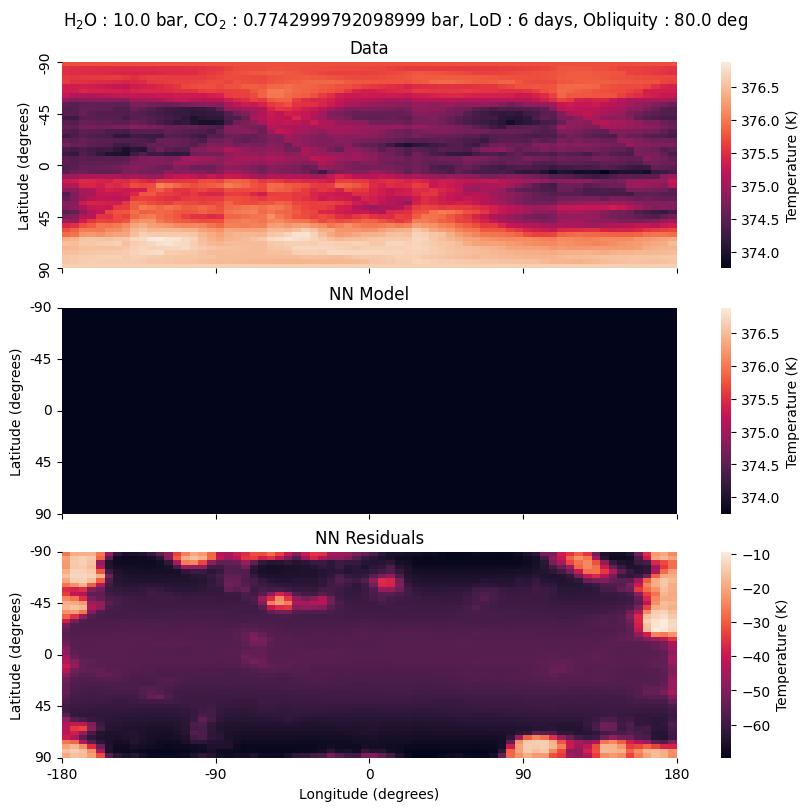

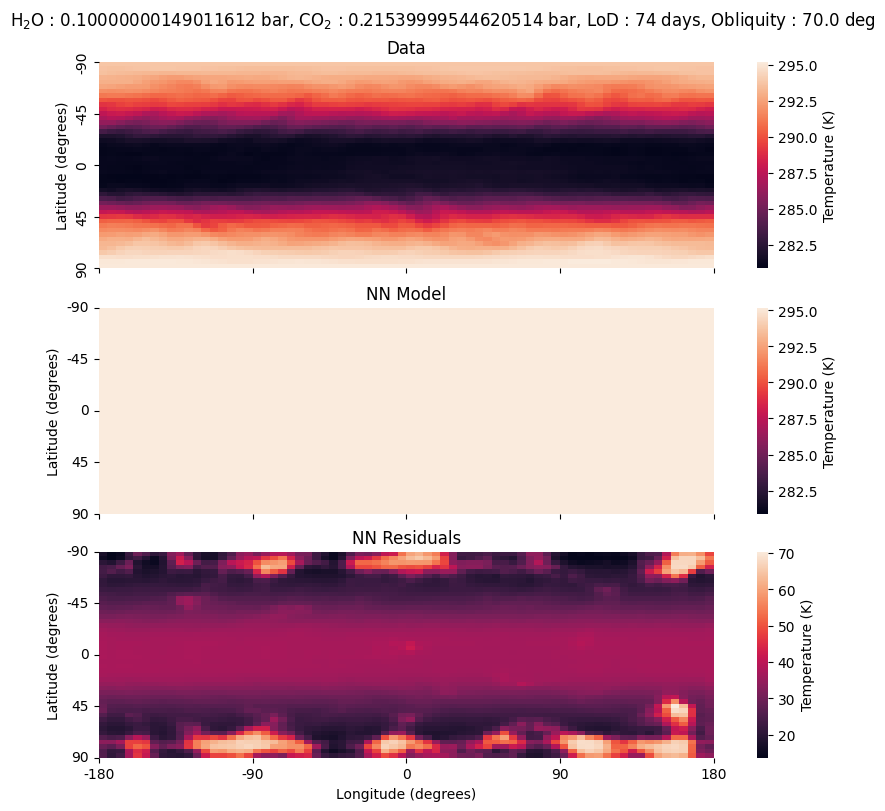

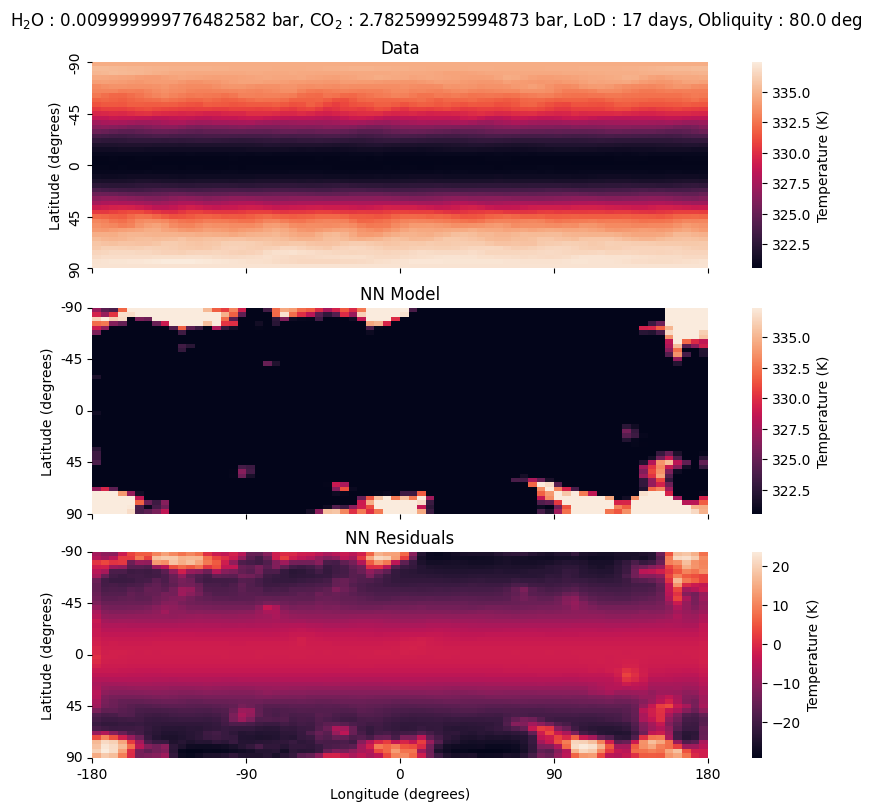

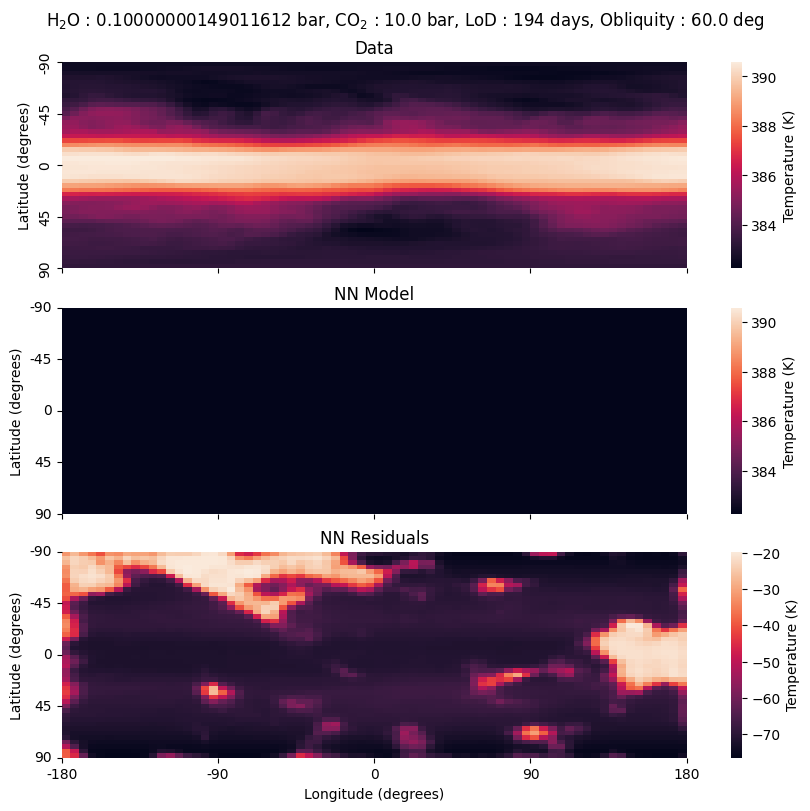

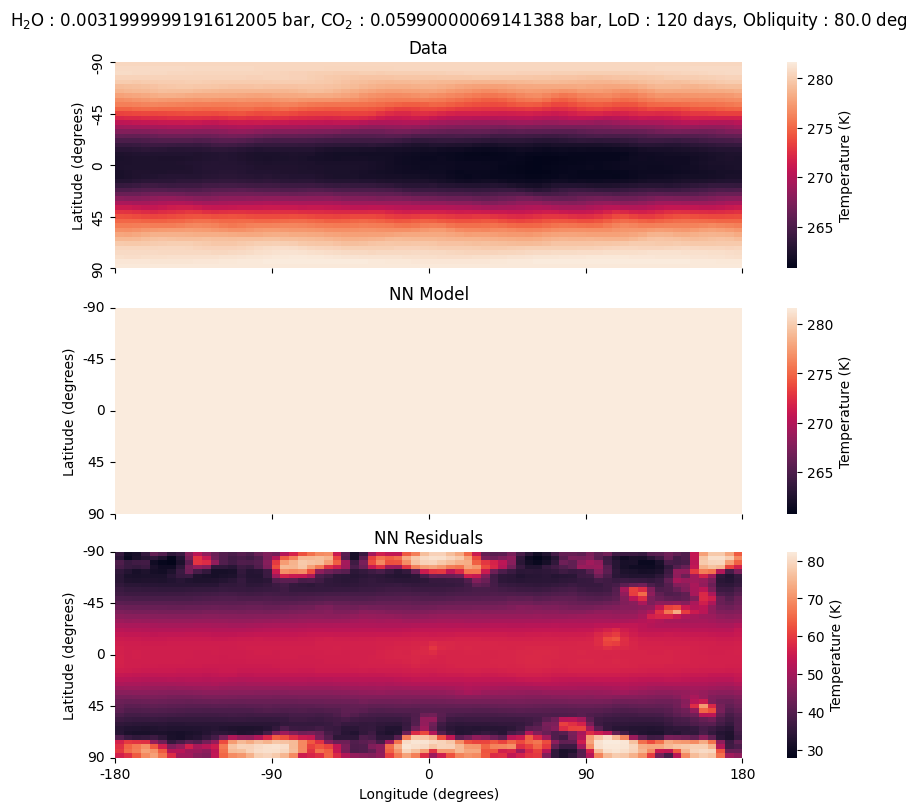

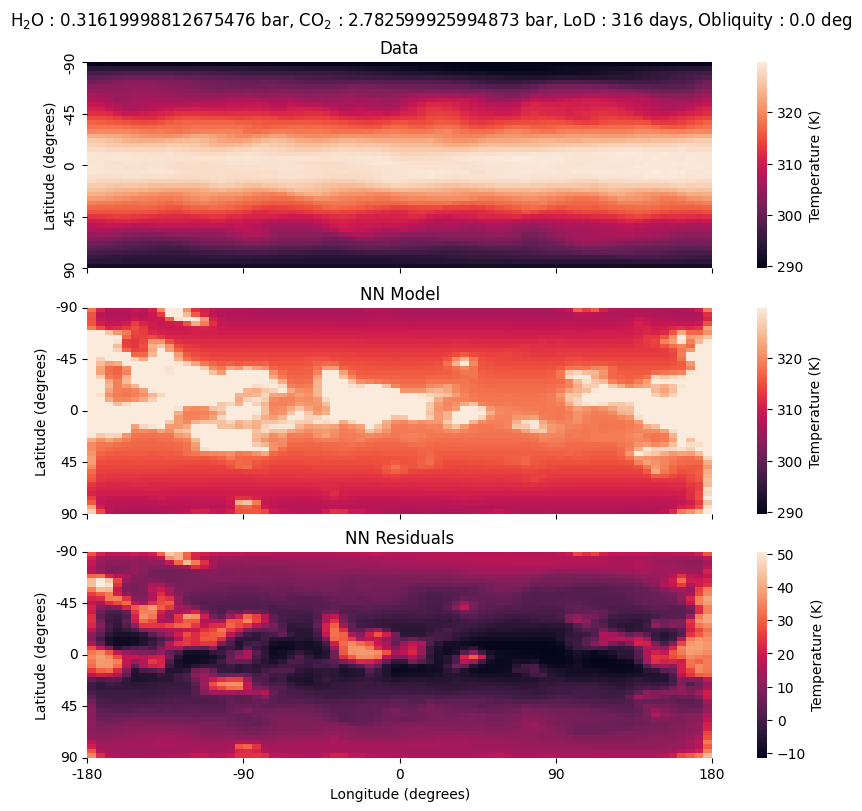

In [10]:
#Comparing predicted T-P profiles vs true T-P profiles with residuals
substep = 100

# Get the scalers from data module
out_scaler = data_module.out_scaler
in_scaler = data_module.in_scaler

#Initialize array to store model outputs
test_NN_outputs = np.zeros(test_outputs.shape, dtype=float)

for test_idx, (test_input, test_output) in enumerate(zip(test_inputs.numpy(), test_outputs.numpy())):

    #Retrieve prediction
    pred_output_scaled = model(torch.tensor(in_scaler.transform(test_input.reshape(1, -1)))).detach().numpy().reshape(3312)
    
    # Inverse transform to get original scale
    test_NN_outputs[test_idx, :] = out_scaler.inverse_transform(pred_output_scaled.reshape(1, -1)).flatten()

    #Plotting
    if (test_idx % substep == 0):

        #Convert shape
        plot_test_output = test_output.reshape((46, 72))
        plot_pred_output = test_NN_outputs[test_idx, :].reshape((46, 72))
        plot_res = plot_pred_output - plot_test_output

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(test_output)
        vmax = np.max(test_output)
        
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1, vmin=vmin, vmax=vmax)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax2.set_title('NN Model')
        hm2 = sns.heatmap(plot_pred_output, ax=ax2, vmin=vmin, vmax=vmax)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax3.set_title('NN Residuals')
        hm3 = sns.heatmap(plot_res, ax=ax3)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm3.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax3.set_xticks(np.linspace(0, 72, 5))
        ax3.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax3.set_xlabel('Longitude (degrees)')
        # Fix latitude ticks
        for ax in [ax1, ax2, ax3]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')
        plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.show()
    

# Compare both methods

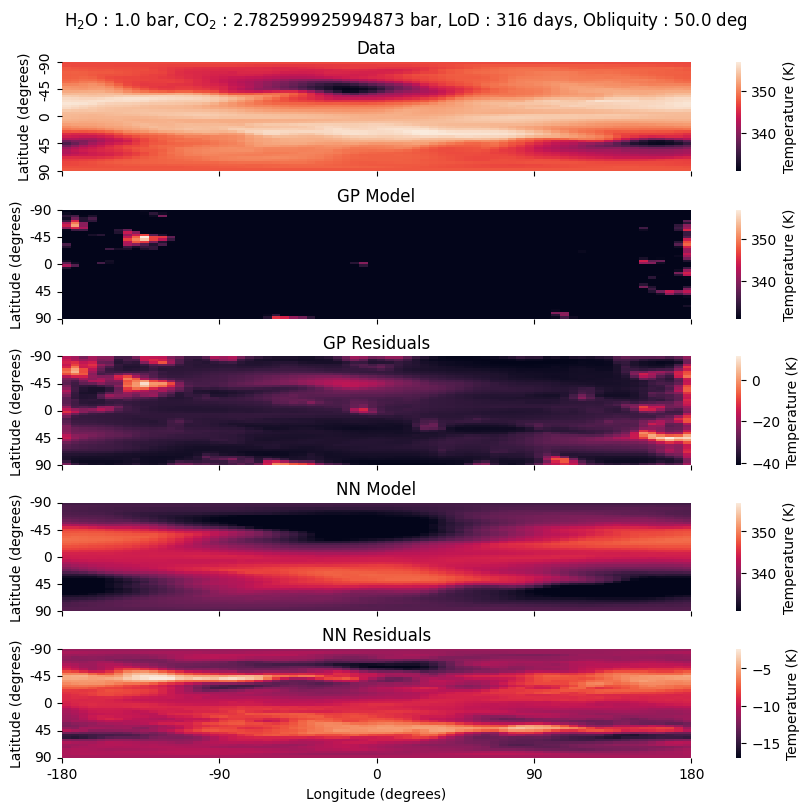

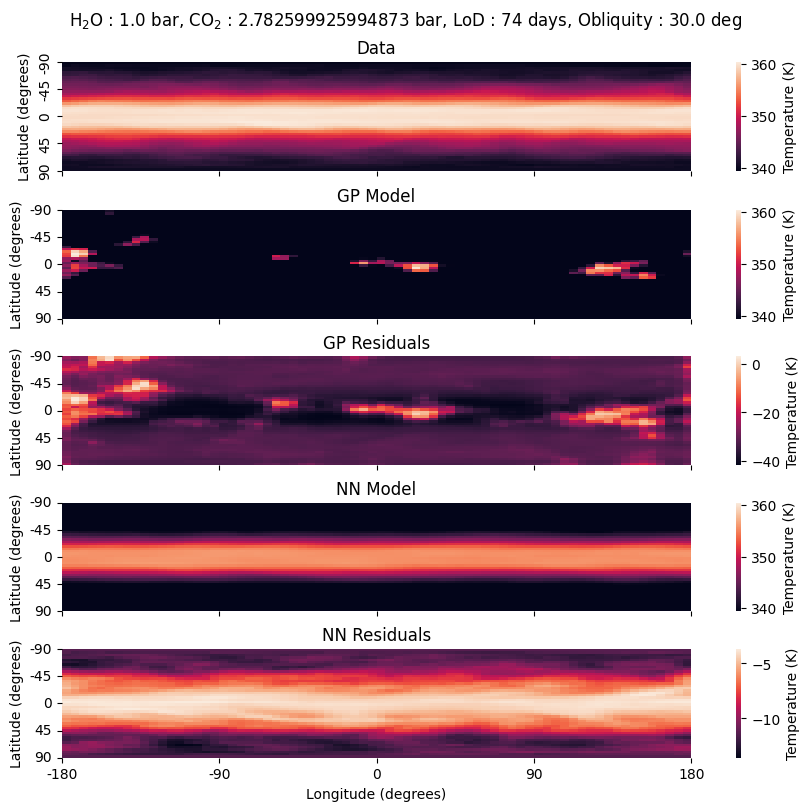

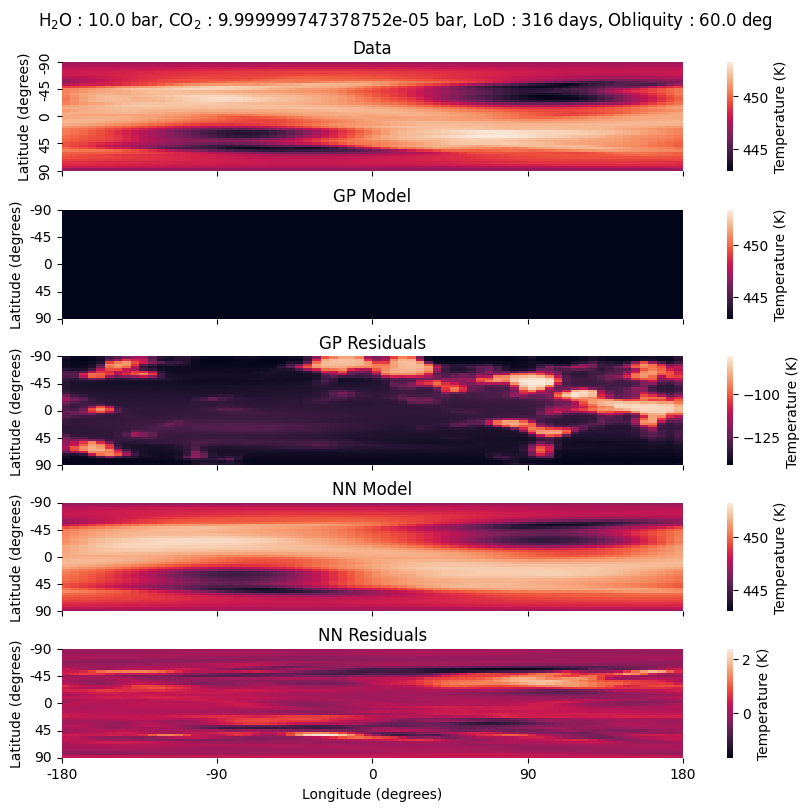

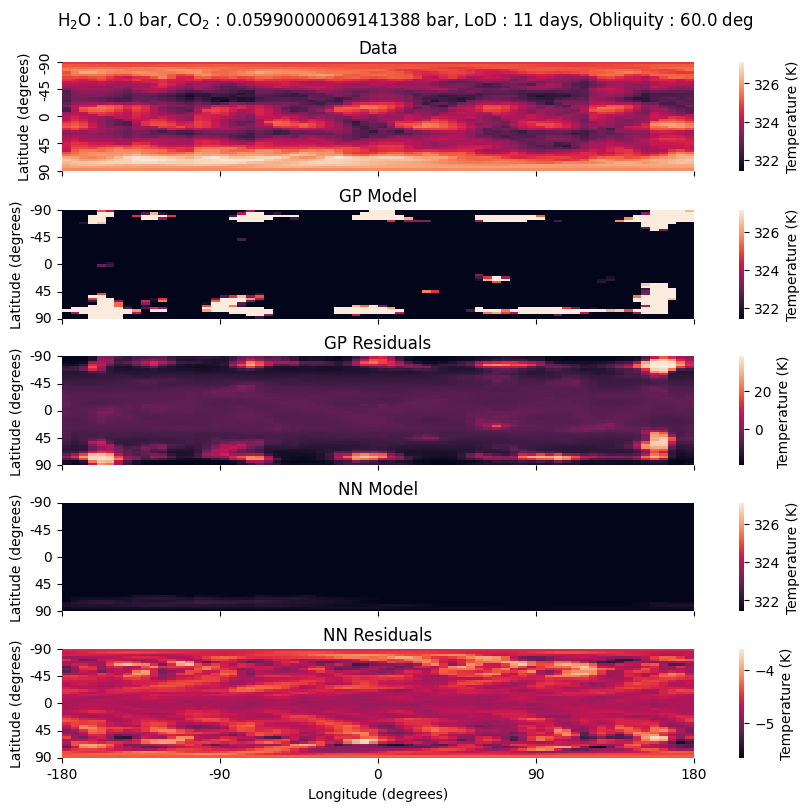

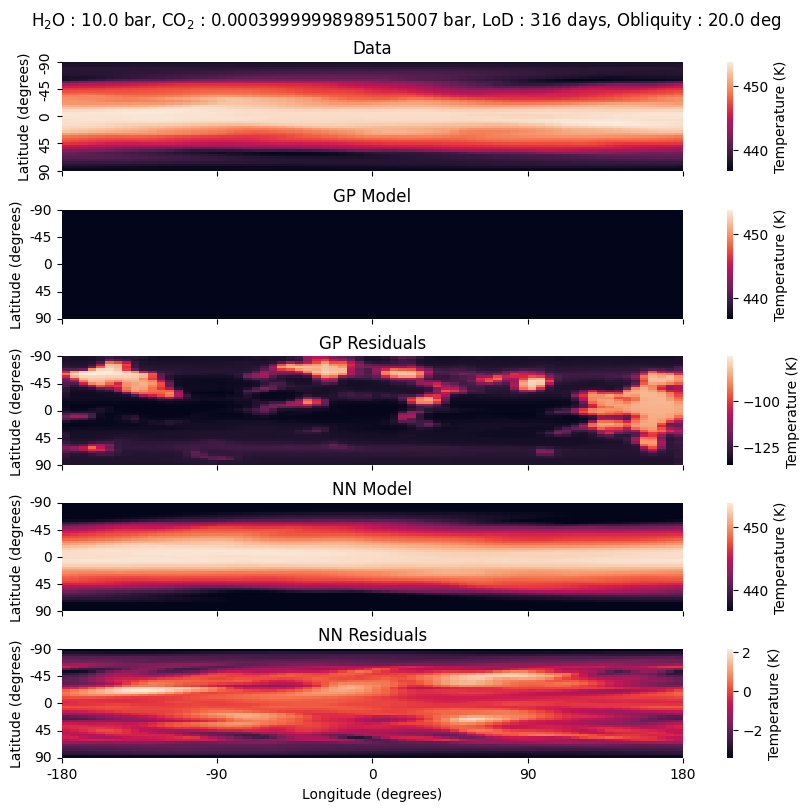

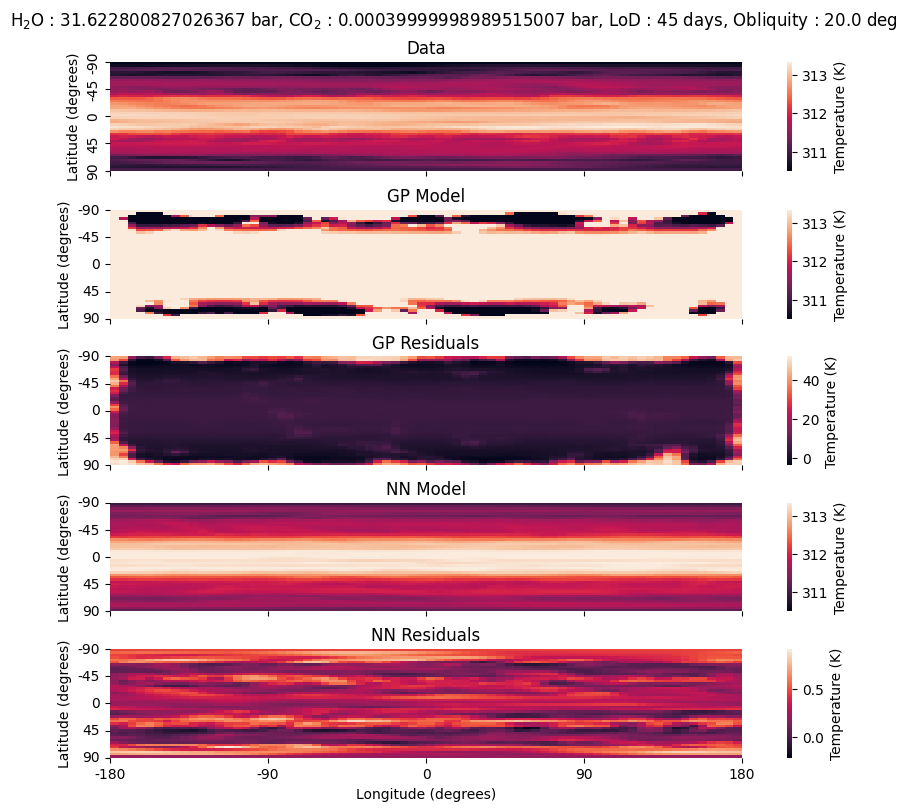

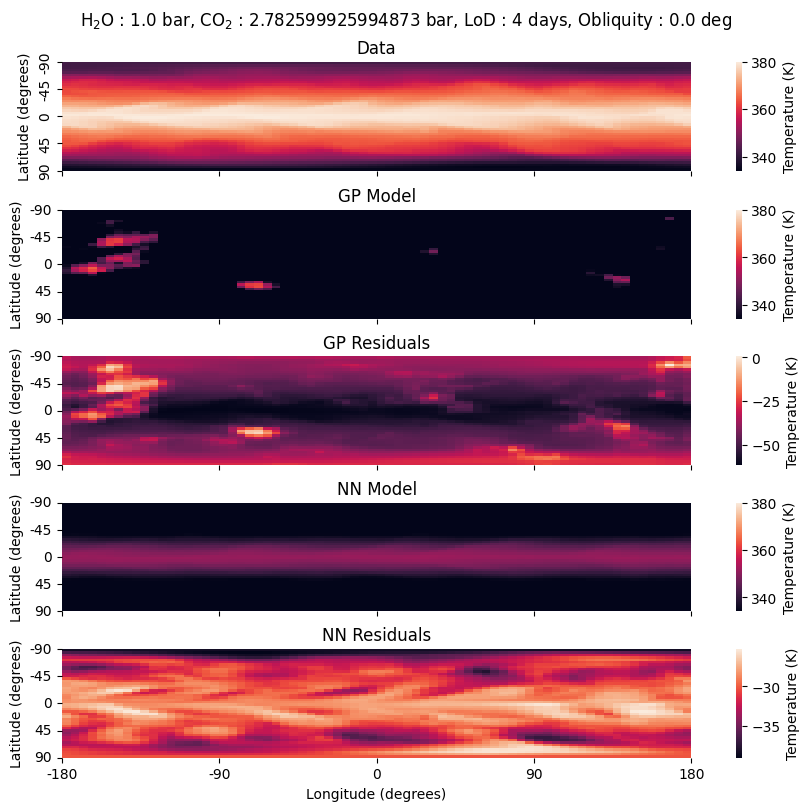

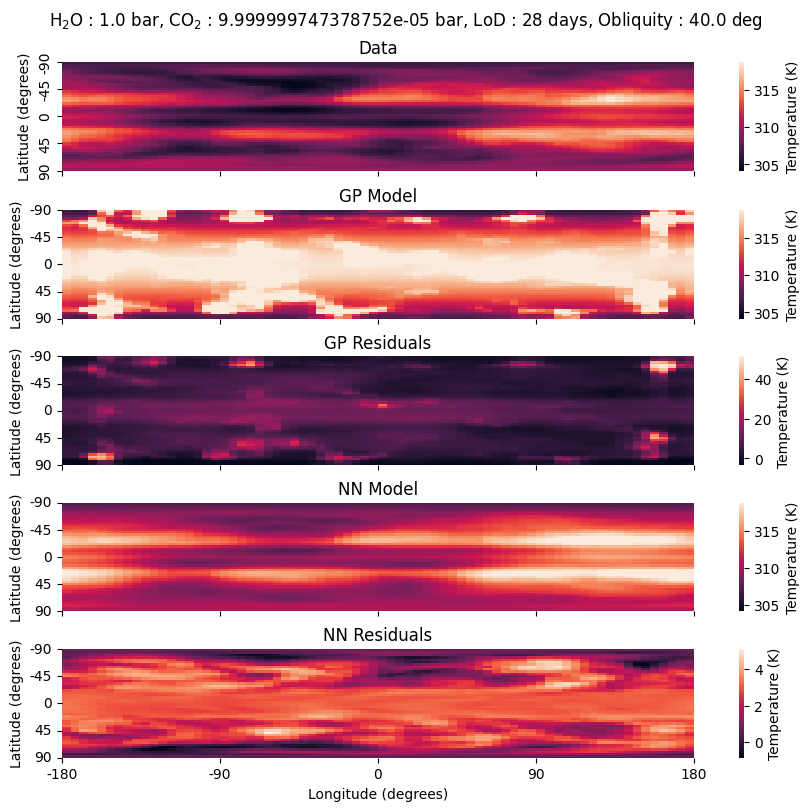

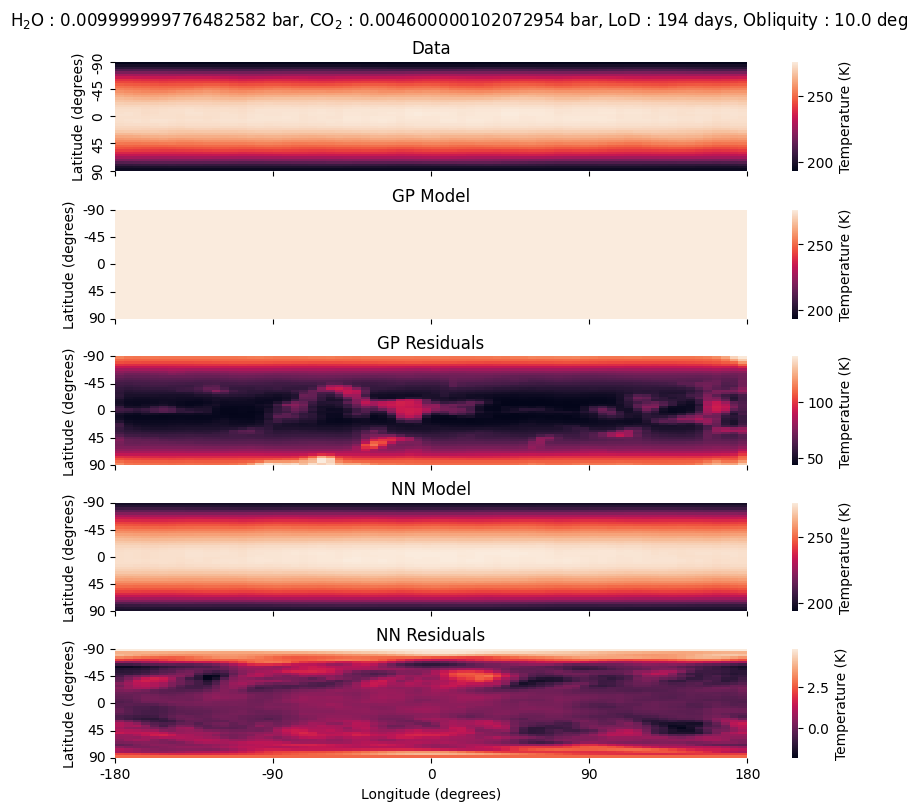

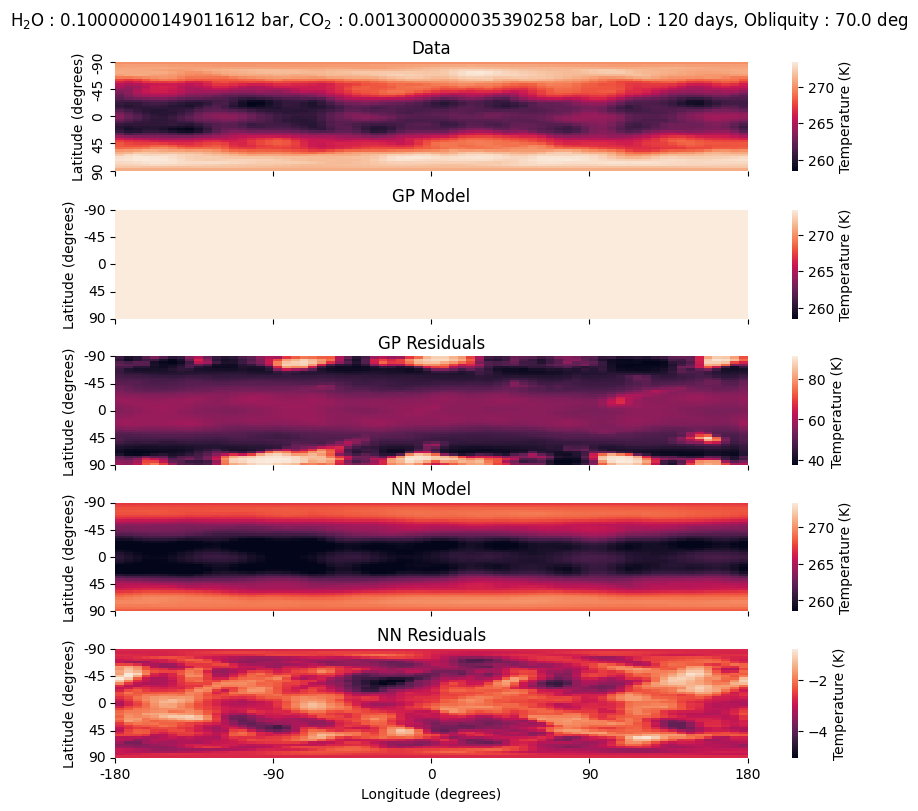

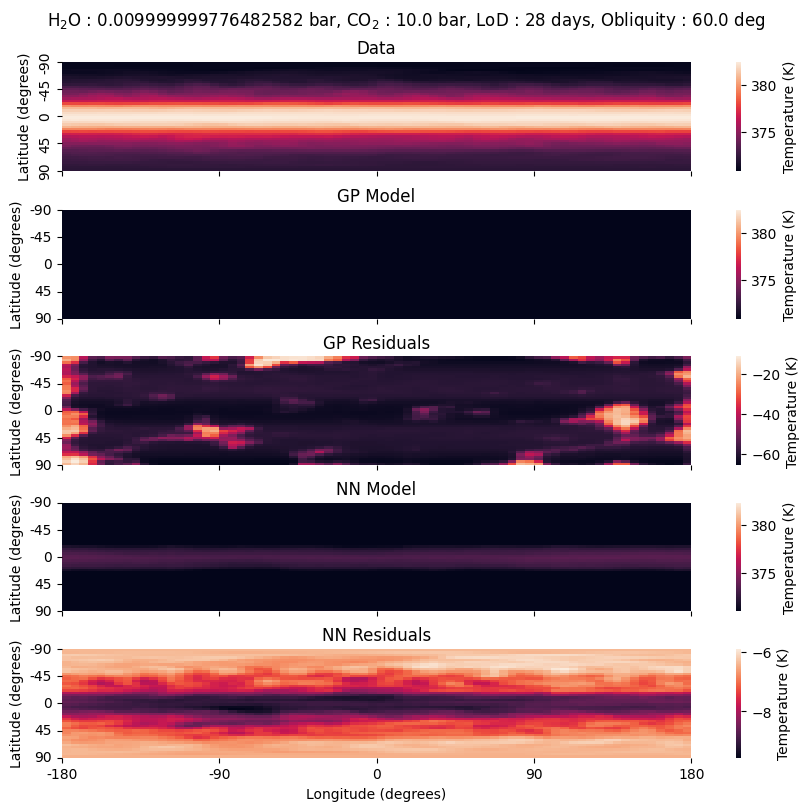

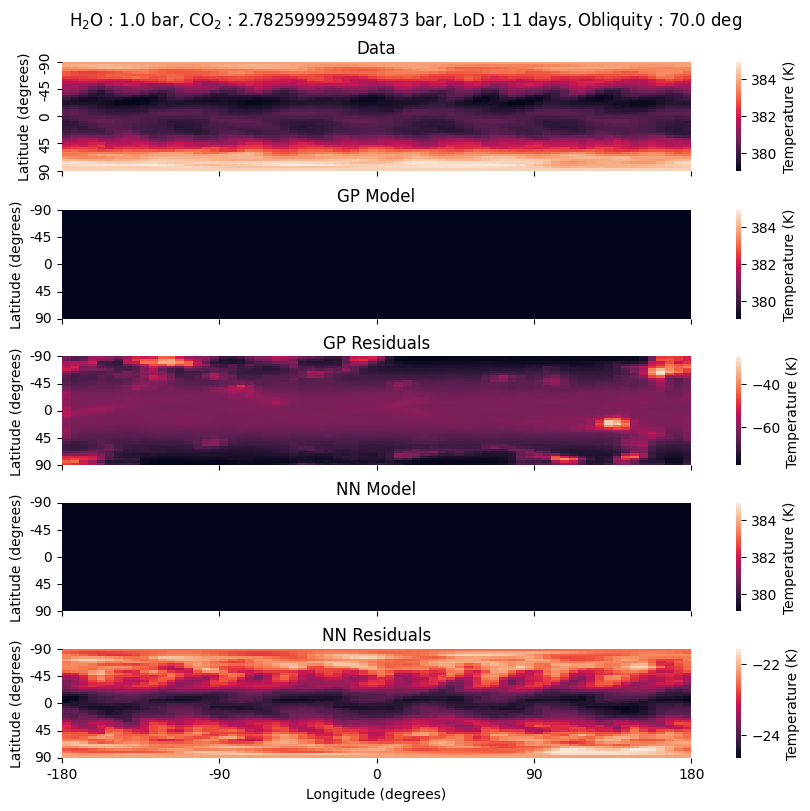

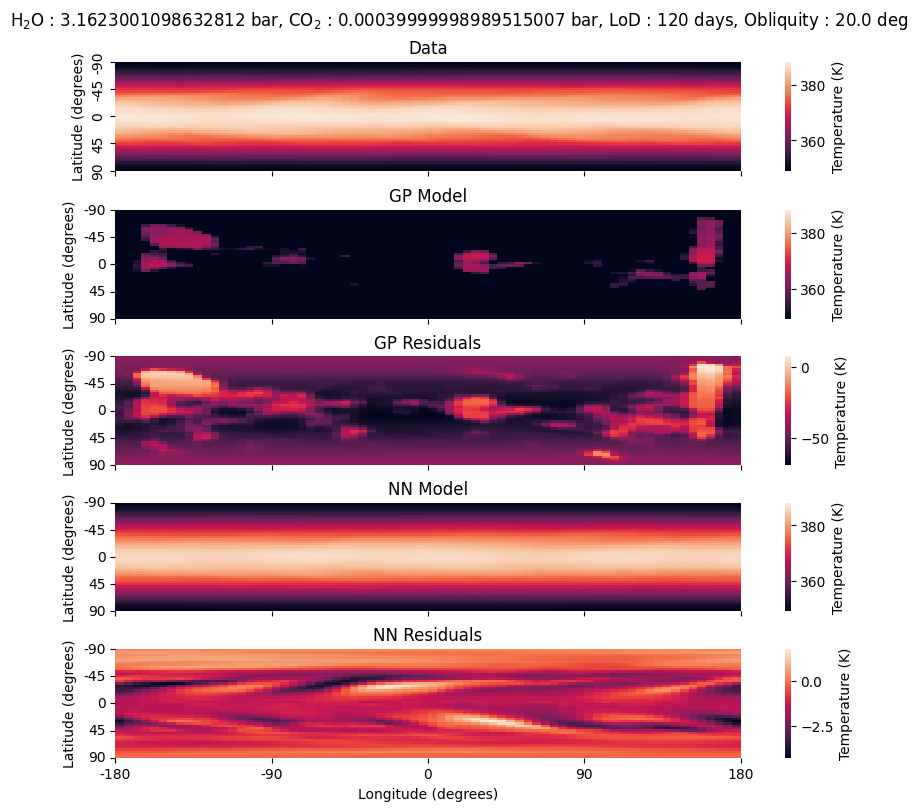

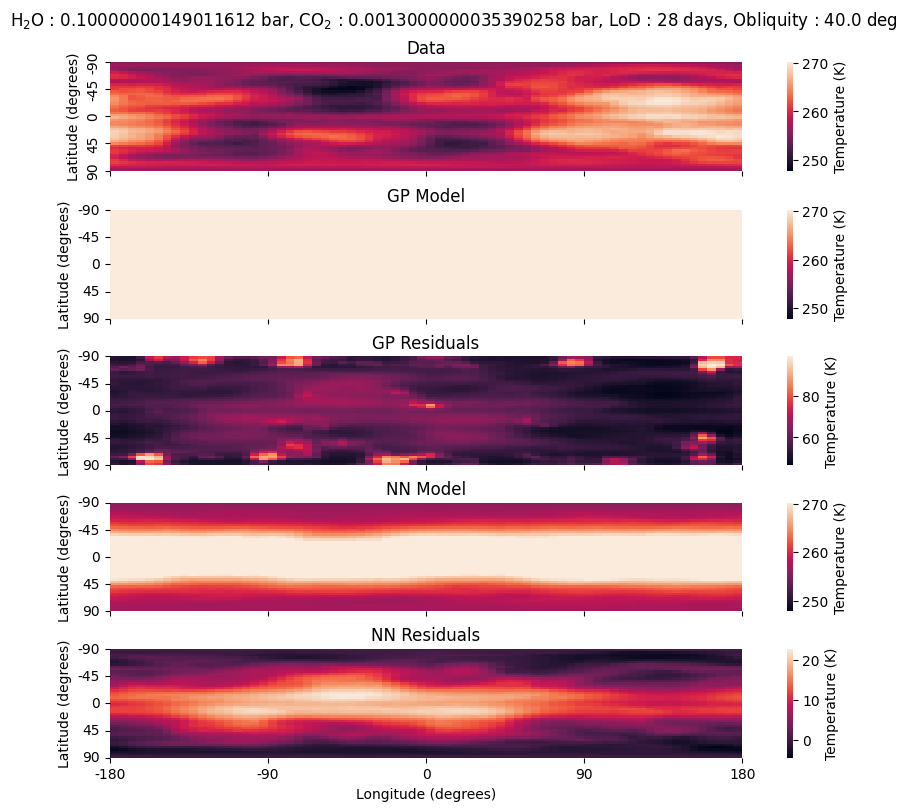

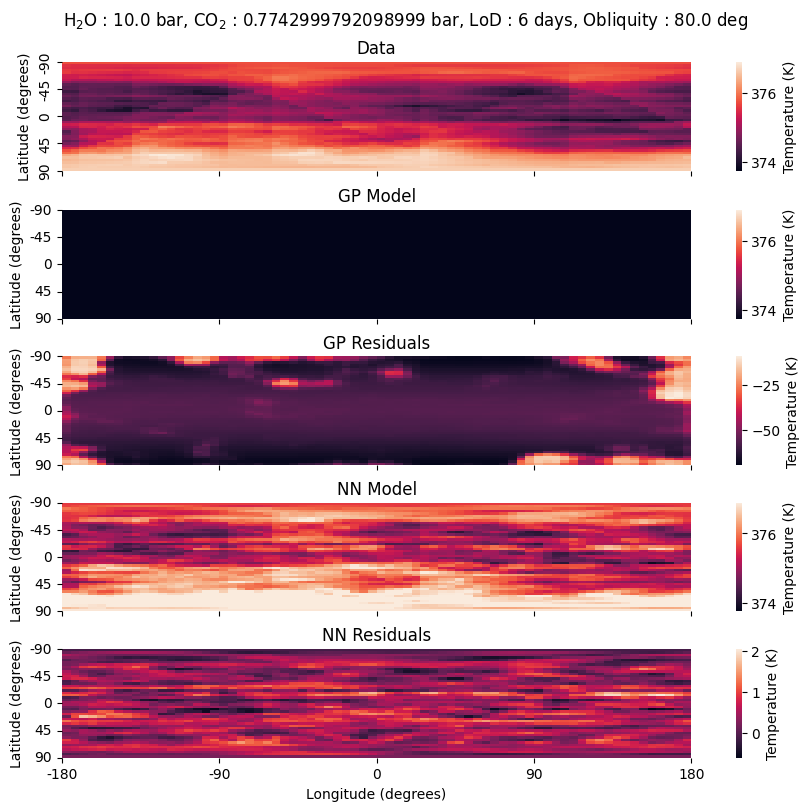

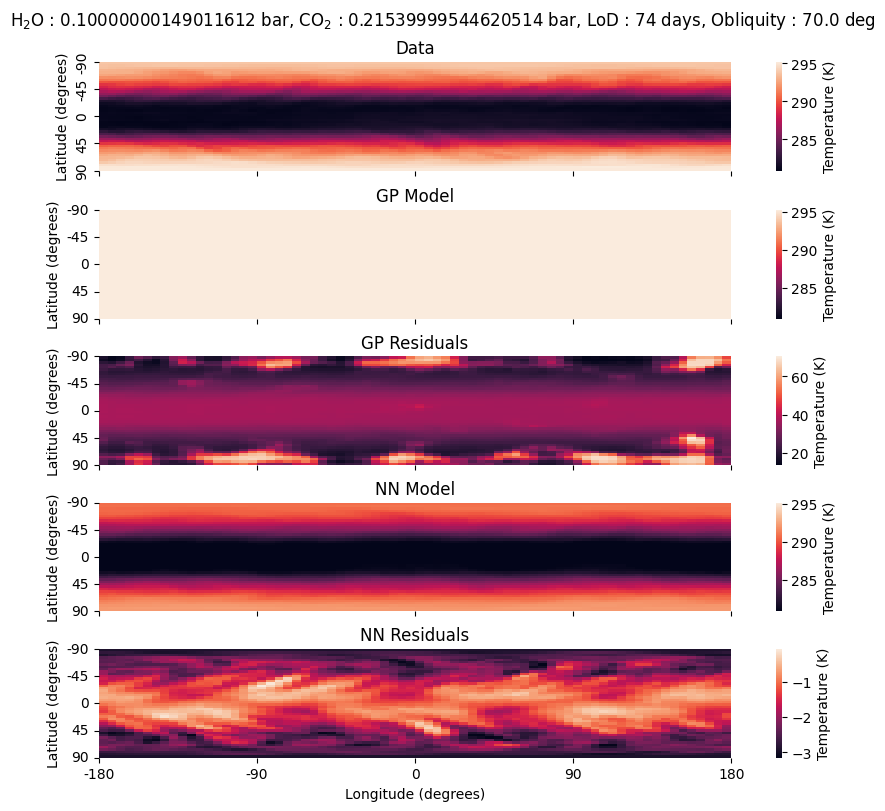

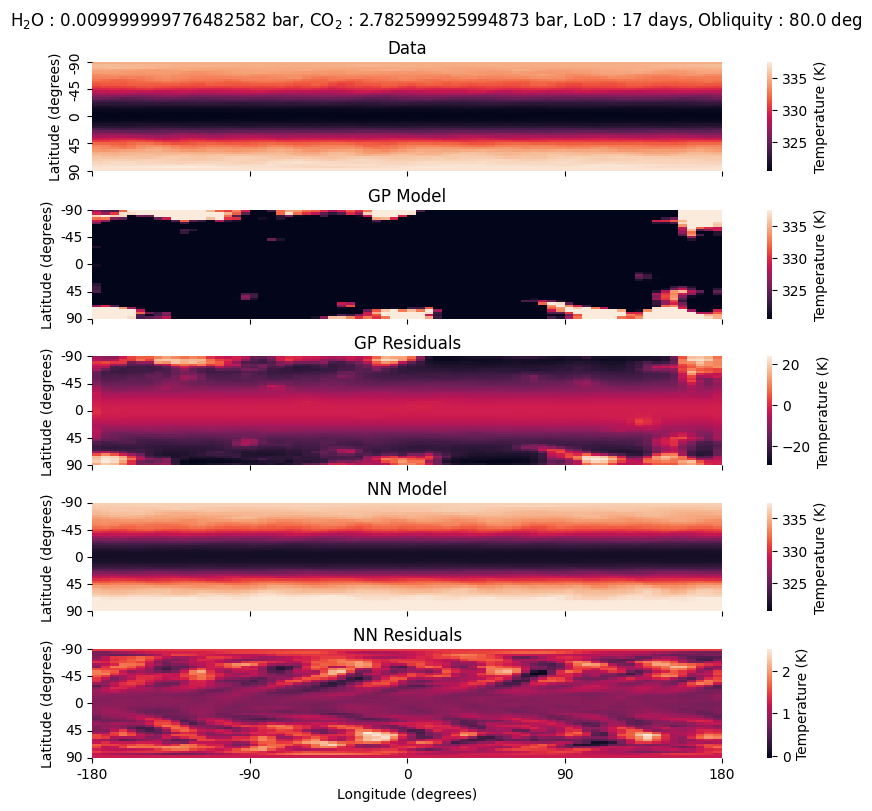

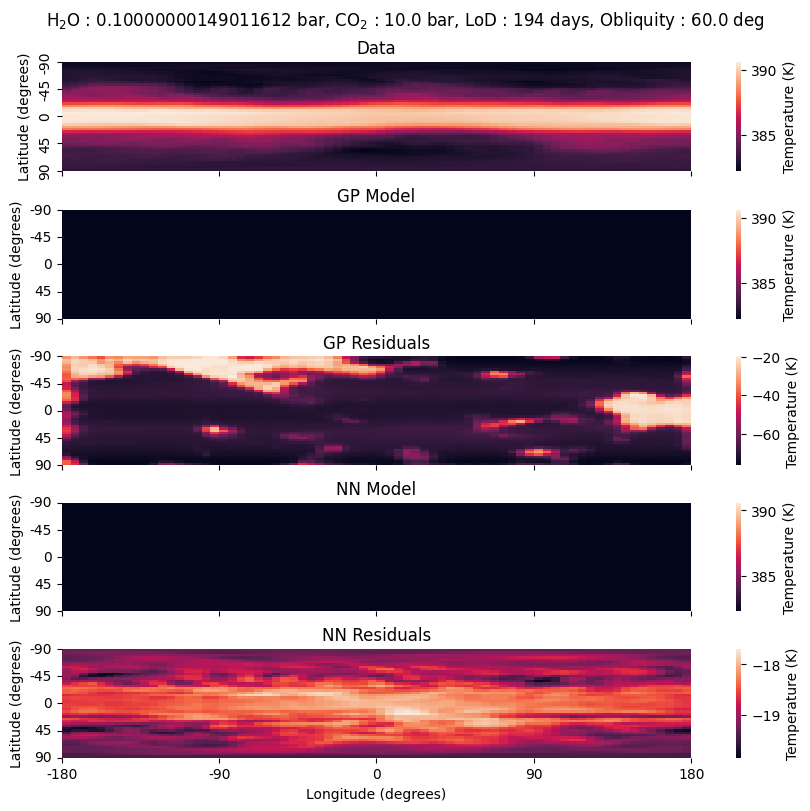

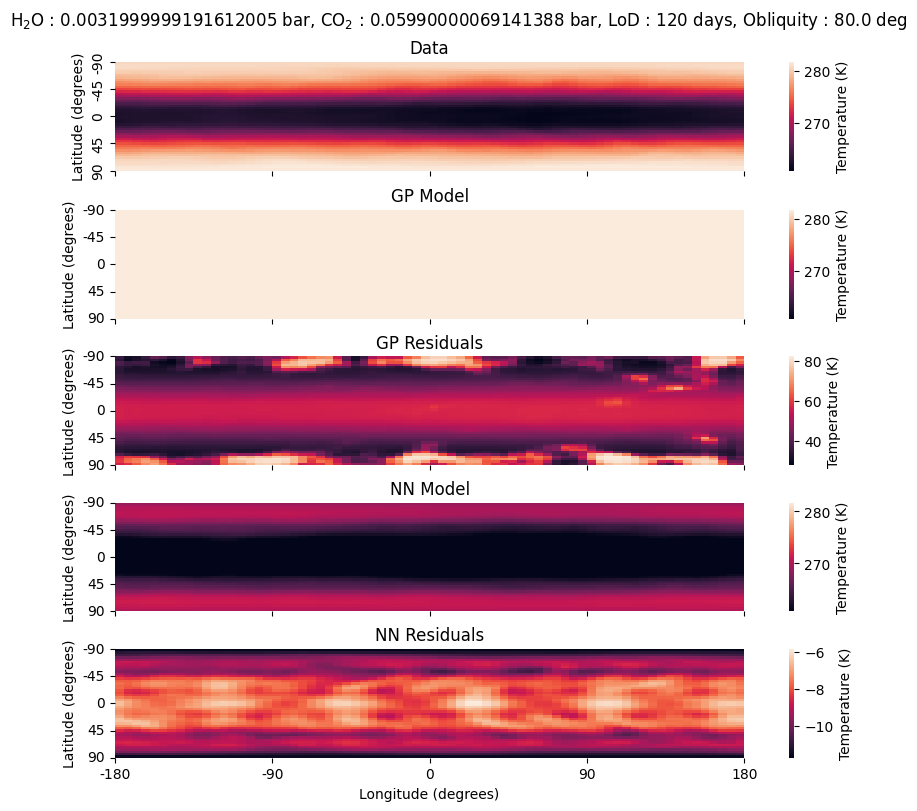

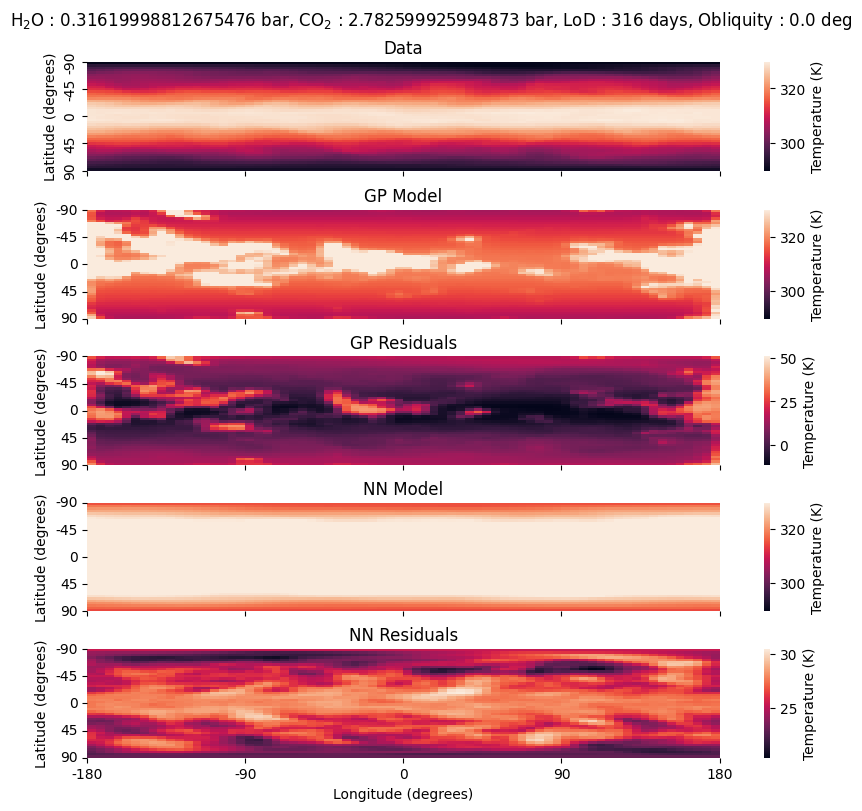

In [11]:
#Comparing GP predicted T-P profiles vs NN predicted T-P profiles vs true T-P profiles
substep = 100

#Initialize array to store model residuals
res_NN_outputs = np.zeros(test_outputs.shape, dtype=float)
res_GP_outputs = np.zeros(test_outputs.shape, dtype=float)

for test_idx, (test_input, test_output) in enumerate(zip(test_inputs.numpy(), test_outputs.numpy())):
    
    #Store residuals 
    res_NN_outputs[test_idx, :] = test_NN_outputs[test_idx, :] - test_output
    res_GP_outputs[test_idx, :] = test_GP_outputs[test_idx, :] - test_output

    #Plotting
    if (test_idx % substep == 0):

        #Convert shape
        plot_test_output = test_output.reshape((46, 72))
        plot_pred_NN_output = test_NN_outputs[test_idx, :].reshape((46, 72))
        plot_pred_GP_output = test_GP_outputs[test_idx, :].reshape((46, 72))
        plot_NN_res = plot_pred_NN_output - plot_test_output
        plot_GP_res = plot_pred_GP_output - plot_test_output

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 8), sharex=True, layout='constrained')        
        
        # Compute global vmin/vmax across all datasets
        vmin = np.min(test_output)
        vmax = np.max(test_output)
        
        # Plot heatmaps
        ax1.set_title('Data')
        hm1 = sns.heatmap(plot_test_output, ax=ax1, vmin=vmin, vmax=vmax)
        cbar = hm1.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax2.set_title('GP Model')
        hm2 = sns.heatmap(plot_pred_NN_output, ax=ax2, vmin=vmin, vmax=vmax)
        cbar = hm2.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax3.set_title('GP Residuals')
        hm3 = sns.heatmap(plot_NN_res, ax=ax3)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm3.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax4.set_title('NN Model')
        hm4 = sns.heatmap(plot_pred_GP_output, ax=ax4, vmin=vmin, vmax=vmax)
        cbar = hm4.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax5.set_title('NN Residuals')
        hm5 = sns.heatmap(plot_GP_res, ax=ax5)#, cbar=False, vmin=vmin, vmax=vmax)
        cbar = hm5.collections[0].colorbar
        cbar.set_label('Temperature (K)')

        ax5.set_xticks(np.linspace(0, 72, 5))
        ax5.set_xticklabels(np.linspace(-180, 180, 5).astype(int))
        ax5.set_xlabel('Longitude (degrees)')
        # Fix latitude ticks
        for ax in [ax1, ax2, ax3, ax4, ax5]:
            ax.set_yticks(np.linspace(0, 46, 5))
            ax.set_yticklabels(np.linspace(-90, 90, 5).astype(int))
            ax.set_ylabel('Latitude (degrees)')

        plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.savefig(plot_save_path+f'/pred_vs_actual_n.{test_idx}.pdf')
        plt.show()
    

--- GP Residuals ---
Median = -0.1253 K, Std = 9.8106 K

 --- NN Residuals ---
Median = 16.7323 K, Std = 52.6956 K


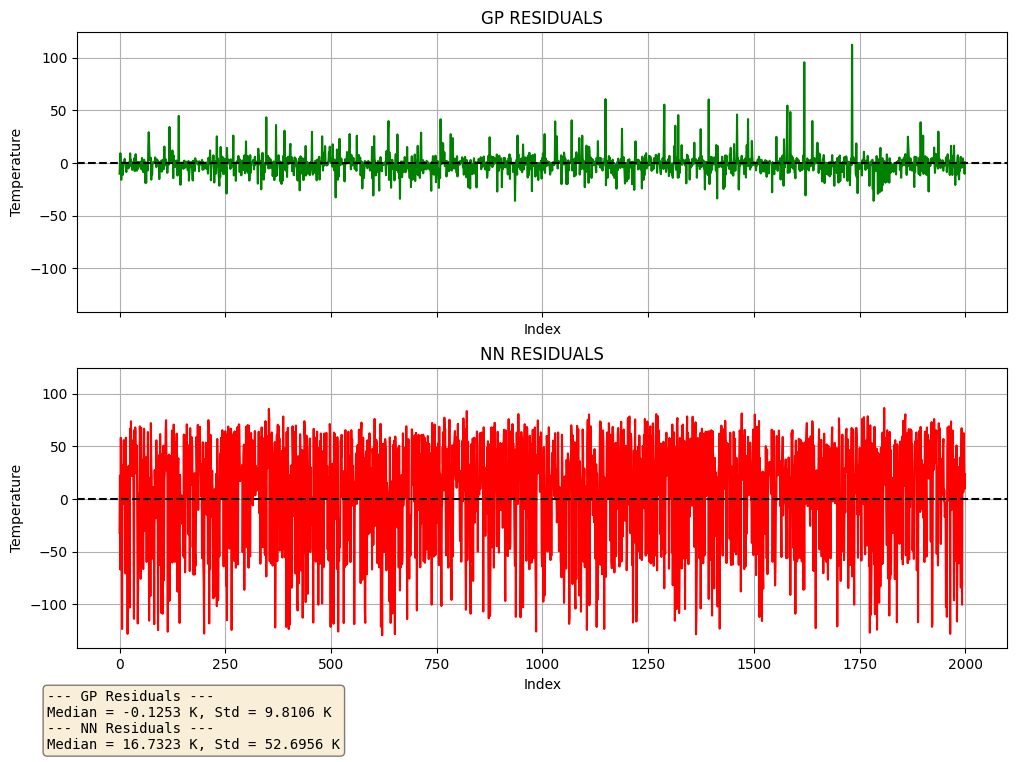

In [12]:
print('--- GP Residuals ---')
print(f'Median = {np.median(res_GP_outputs):.4f} K, Std = {np.std(res_GP_outputs):.4f} K')
print('\n','--- NN Residuals ---')
print(f'Median = {np.median(res_NN_outputs):.4f} K, Std = {np.std(res_NN_outputs):.4f} K')

#Plot residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[12, 8], sharex=True, sharey=True)
ax1.plot(np.mean(res_GP_outputs, axis=1), color='green')
ax2.plot(np.mean(res_NN_outputs, axis=1), color='red')
ax1.set_title('GP RESIDUALS')
ax2.set_title('NN RESIDUALS')
for ax in [ax1, ax2]:
    ax.axhline(0, color='black', linestyle='dashed')
    ax.grid()
ax1.set_xlabel('Index')
ax2.set_xlabel('Index')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Temperature')

# Add statistics text at the bottom
stats_text = (
    f"--- GP Residuals ---\n"
    f'Median = {np.median(res_GP_outputs):.4f} K, Std = {np.std(res_GP_outputs):.4f} K'
    f"\n"
    f"--- NN Residuals ---\n"
    f'Median = {np.median(res_NN_outputs):.4f} K, Std = {np.std(res_NN_outputs):.4f} K'
)

fig.text(0.1, -0.02, stats_text, fontsize=10, family='monospace',
         verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig(plot_save_path+f'/res_GP_vs_NN.pdf', bbox_inches='tight')
plt.show()